# Project (Option 1) - Settlers of Catan 

#### Authors:

v1.0 (2016 Spring) David Marn, Ashvin Nair, Kabir Chandrasekher, Tony Duan, Kangwook Lee, Kannan Ramchandran

v1.1 (2017 Spring) Tavor Baharav, Kabir Chandrasekhar, Sinho Chewi, Andrew Liu, Kamil Nar, David Wang, and Kannan Ramchandran

v1.2 (2018 Spring) Tavor Baharav, Kaylee Burns, Gary Cheng, Sinho Chewi, Hemang Jangle, William Gan, Alvin Kao, Chen Meng, Vrettos Muolos, Kanaad Parvate, Ray Ramamurti, and Kannan Ramchandran

## Introduction
The goal of the game is to get $10$ victory points as fast as possible. To get these points, the player must choose a wise trade-off between spending resources to potentially obtain points and upgrading their modes of production. You, the chieftain of the island, must decide where and when to build additional <font color=purple>settlements</font> on the island to boost your resource production, with roads to connect them. Alternatively, you can invest into development cards, which will bring you a victory point, or upgrade a settlement into a <font color=blue>city</font> which doubles production and gives you another victory point. A settlement / city must border on a resource field in order to harvest its resources. We will have three different terrains: forests, which produce <font color=brown>wood</font>, hills which produce <font color=red>brick</font>, and fields of <font color=gray>grain</font> (grain). Every turn, we roll two dice and record the sum $X$. The settlements that are next to the tile that is labelled with $X$ get one resource from that field, and we keep collecting resources and building up to 10 victory points.

## Game layout

Our modified Catan board is drawn below.

Tiles are color coded with the resource they produce: <font color=brown>wood</font>, <font color=red>brick</font>, <font color=green>grain</font>.

You build <font color=purple>settlements</font> and <font color=blue>cities</font> on vertices of the board. The small purple square is a settlement, labeled "1" because it gives you one resource of the surrounding tiles when the corresponding number is rolled. The small blue square is a city and gives you 2 resources from surrounding tiles.

These settlements and cities must be connected by roads (white).

In [1]:
import numpy as np
from catan import Catan, CatanException, get_random_dice_arrangement, Player, simulate_game, simulate_game_and_save
import matplotlib.pyplot as plt
from itertools import repeat
%matplotlib inline

Drawing...


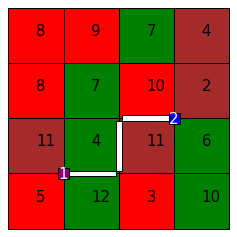

In [52]:
width, height = 4,4
dice = get_random_dice_arrangement(width, height)
resources = np.random.randint(0, 3, (height, width))
board = Catan(dice, resources, [6], [13], [(6, 7), (7, 12), (12, 13)])
board.draw()


## Rules
When implementing your Catan strategy, remember to follow these rules:
<ul>
<li> Every turn you roll 2 dice, call the sum X </li>
<li> Find tiles labeled with the number X and collect one of that resource for every settlement and two of that resource for every city on a vertex of that tile (this logic is implemented for you already) </li>
<li> You can never have more than 6 of any resource: if you get extra, you just keep 6 </li>
<li> You can trade 4 resources of the same kind for a resource of your choice (i.e. 4 grain for 1 wood) </li>
<li> If you have a settlement or a city built on one of the 4 ports (4 corners), you can trade at a discount <ul>
<li> Bottom left hand corner: wood port, trade 2 wood for 1 of any other resource </li>
<li> Bottom right hand corner: brick port, trade 2 brick for 1 of any other resource </li>
<li> Upper left hand corner: grain port, trade 2 grain for 1 of any other resource </li>
<li> Upper right hand corner: general port, trade 3 of any resource for 1 of any other resource </li>
</ul></li>
<li>Settlements must be connected by roads </li>
<li>Roads must be connected to settlements / cities or other roads </li>
<li>Settlements cannot be built adjacent to other settlements or cities </li>
<li> You can build by paying resources according to the costs below, and building any non-road item (including buying a development card) gives you 1 victory point </li>
<li> You start the game off with 3 of each resource and no buildings </li>
<li> You may make as many purchases as you want per turn </li>
<li> You are alloted 3 minutes of computation time per 100 games over a fixed board. </li>
    <ul> <li> You are free to divide this time between planBoard and realtime computation as you wish
        </li> </ul>
</ul>

## Costs
You can build settlements or cities, which boost your production and gain you a victory point, buy roads to enable new settlement buying, or buy development cards which brings you an additional victory point.

The costs are given below, and stored in the array costs for convenience.

In [53]:
import pandas as pd

costs = np.array([[2, 1, 1],
                  [1, 2, 2],
                  [0, 3, 3],
                  [1, 1, 0]])

resources = ['wood', 'brick', 'grain']
buildings = ['settlement', 'card', 'city', 'road']
df = pd.DataFrame(costs, index=buildings, columns=resources)
html = df.to_html()
from IPython.core.display import HTML
HTML(html)

,wood,brick,grain
settlement,2,1,1
card,1,2,2
city,0,3,3
road,1,1,0


The Catan board is implemented for you, with utilities to draw and get a table of resources gained. Feel free to skip this for now, play with the demo below, then come back up to reread the details of the implementation.

 
Here's a short API of the classes and methods implemented in catan.py (which you're encouraged to check out):

#### BOARD CLASS

To initialize a board: 
`board = Catan(dice, resources, settlements, cities)`

The constructor initializes our Catan board. Dice and resources must be the same shape: HxW where H is the height of the board and W is the width. dice[i,j] is the dice number that tile corresponds to (each element between 2-12 inclusive) and resources[i,j] is the resource that tile  provides. Settlements is a list of vertices with settlements on them, and likewise for cities.

`board.build(x,y,building)`
takes in two coordinates, x and y, along with a building type ("city"/"settlement") and builds that building at the specified location. If the building cannot be built at that location, an exception is thrown.

`board.build_road(c0,c1)`
takes in two vertex location tuples (x0,y0) and (x1,y1), and builds a road between the two vertices. If the road cannot be built at that location, an exception is thrown.

`board.if_can_build(building,x,y)`
returns False if a building cannot be built at that vertex. Otherwise, it returns True.

`board.if_can_build_road(v1,v2)`
returns False if a road cannot be built between vertices v1 and v2. Otherwise, it returns true.

`board.is_port(vertex)`
returns True if vertex is located on a port, False otherwise.

`board.which_port(v)`
returns which port vertex v corresponds to (0 : wood port, 1 : brick port, 2 : grain port, 3 : general port).

`board.get_resources()`
returns a 11x3 numpy array of resources gained for each possible dice sum. That is, r[i, :] = resources gained from throwing a (i+2).

`board.draw()`
draws the board


#### PLAYER CLASS

`player = Player(action,board,resources,points=0,turn_counter=0)`
Where a board is a Catan board, an action is a function, resources is an array, points and turn_counter are integers used for debugging.

`player.if_can_buy(item)` 
returns True if the player can afford item ("card"/"settlement"/"city") and False otherwise

`player.buy(item)` 
actually buys the item and throws a CatanException if that is not possible. Note that you need to specify the location of an item with the optional arguments `x`,`y` if you are buying a city, settlement, or road.

`player.trade(r_in,r_out)`
Trades resource r_in for r_out with ratio 4:1, unless player owns a port allowing for better trades. Throws an exception if player does not have the required amount of resource r_in to complete the trade.

`player.play_round()` 
plays one round of Catan: rolls the dice, collects the resources and calls the function action()


#### TESTING

`simulate_game(action, planBoard, board, num_trials)`
Simulates $num\_trials$ games on $board$, with the precompute method $planBoard$ to be used beforehand, and the $action$ method to be used during the game.


##  <font color=blue>$\mathcal{Q}$1. Learning the Game</font>

Drawing...
[[ 0.  1.  0.]
 [ 2.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  2.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  2.]
 [ 0.  2.  0.]]


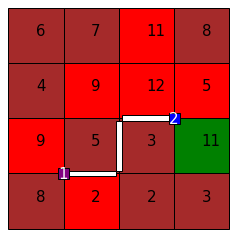

In [34]:
my_board = board
board.draw()
print(board.get_resources())

# wood is brown, brick is red, grain is green 
# below is the resource outcome of a dice roll 2-12

## Game Simulation

Run the code below to see a game in action! This will use our (bad) sample policy.

In [5]:
# sample action function: takes in the "Player"
def action(self):
    # inputs:
    # resources - an array of resources
    # costs - an array of costs, 0 - settlement, 1 - card, 2 - city
    # basic strategy: Once we get 4 of one resource, we make a trade. 
    # Then we try to buy development cards
    if self.board.settlements == []:
        (x,y) = self.preComp #use the optimal settlement location  
        self.buy("settlement", x, y) # we determined previously
    elif self.if_can_buy("card"):
        self.buy("card")
    elif self.resources[np.argmax(self.resources)] >= 4:
        rmax, rmin = np.argmax(self.resources), np.argmin(self.resources)
        self.trade(rmax, rmin)
    return

def planBoard(baseBoard):
    x = np.random.randint(0, baseBoard.width+1)
    y = np.random.randint(0, baseBoard.height+1)
    optSettlementLoc = (x,y)
    return optSettlementLoc
    
num_trials = 100

width, height = 4, 4
dice = get_random_dice_arrangement(width, height)
resources = np.random.randint(0, 3, (height, width))
board = Catan(dice, resources)
print(simulate_game(action, planBoard, board, num_trials))

950.48


In [6]:
settlements, cities, roads, hands, live_points, dice_rolls = simulate_game_and_save(action, planBoard, board)

def draw(t):
    t = int(t)
    live_board = Catan(board.dice, board.resources, [], [])
    live_board.settlements = settlements[t]
    live_board.cities = cities[t]
    live_board.roads = roads[t]
    print("turn:", t)
    print("points:", live_points[t])
    print("dice roll:", dice_rolls[t])
    print("resources:", hands[t])
    live_board.draw()

turn: 393
points: 5
dice roll: 4
resources: [ 3.  0.  2.]
Drawing...


<function __main__.draw>

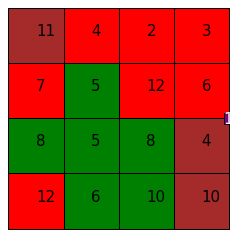

In [7]:
#If this cell doesn't work, run the two commands below in terminal
# pip install ipywidgets
# jupyter nbextension enable --py --sys-prefix widgetsnbextension

from ipywidgets import *
interact(draw, t=(0, len(live_points) - 1, 1))

You are responsible for designing a good action / planning policy. Keep in mind that you are only allowed to modify these two methods, and that your action / planBoard functions must operate within a time constraint (under 3 minutes for 100 trials on a fixed board).

##  <font color=blue> Efficient Optimization [OPTIONAL]
### <font color=blue> This is just one suggestion of how to proceed. The important thing is to separate the adversarial real world game of Catan from this simulation, and to think in a stochastic optimization mindset. </font>

In the final phase of the project, use the tools you wrote above to figure out the best action sequence to minimize the time until you reach 10 points. To make our calculations tractable we can compute something a little different than finding the optimum action over all actions and all possible game states. Instead, we can reduce the goal at any given moment to building the _next_ objective. In this framework, we need to minimize the expected time from having no resources to building each objective. The below questions are optional but we recommend at least looking over them to see the topics we cover in class from a computing point of view, and it can be part of your "extension" to the project.

Below are a few more utility functions you may use to handle converting state triplets into integers.

In [8]:
# hand = (w, b, g)
LIMIT = 7 # can have 0-6 of each resource

def encode(w, b, g):
    return LIMIT * LIMIT * w + LIMIT * b + g

def decode(n):
    x = n % (LIMIT * LIMIT)
    return (n // (LIMIT * LIMIT), x // LIMIT, x % LIMIT)

In [54]:
l = np.array((LIMIT-1, LIMIT-1, LIMIT-1))
def floor(state):
    return np.minimum(l, state)

Drawing...
[[ 0.  0.  2.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]
 [ 0.  2.  0.]
 [ 0.  1.  0.]
 [ 2.  0.  0.]
 [ 0.  2.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]


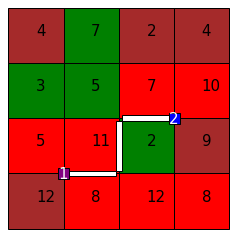

In [59]:
width, height = 4,4
dice = get_random_dice_arrangement(width, height)
resources = np.random.randint(0, 3, (height, width))
board = Catan(dice, resources, [6], [13], [(6, 7), (7, 12), (12, 13)])
board.draw()
print(board.get_resources())

### <font color=blue> 1. Create a function `get_transition_matrix` which returns the transition matrix of your Markov chain. </font>

In [63]:
def transition_matrix(board):
    """returns matrix T[i, j] = P(transition from state i to state j)"""
    DICE_ROLL_PROBS = 1/36 * np.array([1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1])
    resources = board.get_resources()
    # print(resources)
    P = np.zeros((343, 343))
    for i in range(343):
        w, b, g = decode(i)
        for k, recieved_resources in enumerate(resources):
            wresc, bresc, gresc = recieved_resources
            wnew, bnew, gnew = min(6, w + wresc), min(6, b + bresc), min(6, g + gresc)
            j = encode(wnew, bnew, gnew)
            P[i][j] += DICE_ROLL_PROBS[k]
    return P


T = transition_matrix(board)
print(T)
T[encode(0, 0, 0)][encode(0, 2, 0)]

[[ 0.27777778  0.          0.02777778 ...,  0.          0.          0.        ]
 [ 0.          0.27777778  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.27777778 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.97222222  0.          0.02777778]
 [ 0.          0.          0.         ...,  0.          0.97222222
   0.02777778]
 [ 0.          0.          0.         ...,  0.          0.          1.        ]]


/Users/jtstog/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.25

##  <font color=blue> Calculating Hitting Time</font>

Let's start by building a useful function to answer the question: given a board layout and starting resources, how long will it take until you can afford a specific building?

Hint: one method would be to create another Markov chain/transition matrix where the hitting time between two of the states gives the time until you can afford a building.

### <font color=blue> 2a. Write a function to calculate mean hitting time from 0 resources until you can afford a building.

In [86]:
from time import time
def hitting_time(P, w_needed, b_needed, g_needed):
    ### your code here
    P = P - np.eye(343)
    to_delete = []
    for w in range(w_needed, 7):
        for b in range(b_needed, 7):
            for g in range(g_needed, 7):
                to_delete.append(encode(w, b, g))
    for j in reversed(sorted(to_delete)):
        P = np.delete(P, j, axis=1)
        P = np.delete(P, j, axis=0)
    t = time()
    neg_one = -np.ones(343-len(to_delete))
    beta = np.linalg.solve(P, neg_one)
    print(time() - t)
    indices = sorted(list(set(range(343))-set(to_delete)))
    return indices, beta

indexes, beta = hitting_time(T, 5, 0, 0) # calculates time until we can afford a VP card
print(beta)

0.0008242130279541016
[ 22.36032  22.36032  22.36032  22.36032  22.36032  22.36032  22.36032
  22.36032  22.36032  22.36032  22.36032  22.36032  22.36032  22.36032
  22.36032  22.36032  22.36032  22.36032  22.36032  22.36032  22.36032
  22.36032  22.36032  22.36032  22.36032  22.36032  22.36032  22.36032
  22.36032  22.36032  22.36032  22.36032  22.36032  22.36032  22.36032
  22.36032  22.36032  22.36032  22.36032  22.36032  22.36032  22.36032
  22.36032  22.36032  22.36032  22.36032  22.36032  22.36032  22.36032
  17.0496   17.0496   17.0496   17.0496   17.0496   17.0496   17.0496
  17.0496   17.0496   17.0496   17.0496   17.0496   17.0496   17.0496
  17.0496   17.0496   17.0496   17.0496   17.0496   17.0496   17.0496
  17.0496   17.0496   17.0496   17.0496   17.0496   17.0496   17.0496
  17.0496   17.0496   17.0496   17.0496   17.0496   17.0496   17.0496
  17.0496   17.0496   17.0496   17.0496   17.0496   17.0496   17.0496
  17.0496   17.0496   17.0496   17.0496   17.0496   17.0496  

### <font color=blue> 2b. Simulate the Markov process and record the expected hitting time to states to check the accuracy of your hitting time function. </font>

In [81]:
# simulator goes here
from random import randint
def f():
    n = 0
    i = 0
    while n < 5:
        r = randint(1, 6) + randint(1, 6)
        if r == 9:
            n+=2
        if r == 12:
            n+=1
        i+= 1
    return i
N = 100000
print(sum(f() for _ in range(N)) / N)

22.35408


Now you can minimize total expected hitting time with your policy using your hitting time function to speed up the optimization instead of simulating everything.